import sys
!conda install --yes --prefix {sys.prefix} imutils

Data pre-processing == " move smaller images "
Use New dataset - Re-calculate  weights for loss function
Alexnet_50_x_50 + NewDataset
CONV + GAP

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
#import tensorflow_addons as tfa
import numpy as np
import argparse
import cv2
import os
import shutil
%matplotlib inline

2.2.0


class SppnetLayer(Layer):
    '''This layer takes an input tensor and pools the tensor
      in local spatial bins.
      This layer uses Max pooling.
      It accepts input in tensorflow format. # channels last

    # Input
        list of filter in form [x,y,z] 
    # Input shape : 4d tensor [None, X,Y, channels]
    # Output shape : 3d tensor [None,pooled dim, channels] 

    '''
    def __init__(self, filters = [1], **kwargs):
        self.filters = filters
        super(SppnetLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        length = 0;
        for f_size in self.filters:
            length+= (f_size*f_size)
        return (input_shape[0],length*input_shape[3])
      
    def get_config(self):
        config = {'filters': self.filters}
        base_config = super(SppnetLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
      output = []
      for f_size in self.filters:
        win_size = K.int_shape(inputs)[1]/f_size
        #print(win_size)
        win_size = int(win_size)
        for x_start in range(0,f_size):
          for y_start in range(0,f_size):
            X = int(x_start*win_size)
            Y = int(y_start*win_size)
            result = K.max(inputs[:,X:X+win_size,Y:Y+win_size,:],axis = (1,2))
            output.append(result)
      output = K.concatenate(output)
      return output

In [21]:
datasetPath="./classes-VIS"
datasetTestPath="./classes-VISTest"

classBi="bicycle"
classCar="car"
classBus="bus"
classTruck="truck"
classVan="van"
classMotor="motor"

batch_size = 32
img_height = 50
img_width = 50

noBi=7579
noBus=5035
noCar=114165
noMotor=20455
noTruck=10790
noVan=20508
noClasses=6
noTotal=178532

#data pre-processing functions

def movers(classOldPath,classNewPath):
    imgList=os.listdir(classOldPath)
    L=len(imgList)
    moves=0
    for i in range(L):
        img=cv2.imread(os.path.join(classOldPath,imgList[i]))
        if (img.shape[0] < 20 and img.shape[1] < 20):
            shutil.move(os.path.join(classOldPath,imgList[i]),os.path.join(classNewPath,imgList[i]))
            moves = moves + 1
    print("Total moves==> ", moves)   
    

#data pre-processing TEST
datasetNewTestPath="./VISTEST-20x20"
#Bicycle class 
classOldPath=os.path.join(datasetTestPath,classBi)
classNewPath=os.path.join(datasetNewTestPath,classBi)
movers(classOldPath,classNewPath) 

#Bus class 
classOldPath=os.path.join(datasetTestPath,classBus)
classNewPath=os.path.join(datasetNewTestPath,classBus)
movers(classOldPath,classNewPath) 

#Car class 
classOldPath=os.path.join(datasetTestPath,classCar)
classNewPath=os.path.join(datasetNewTestPath,classCar)
movers(classOldPath,classNewPath) 

#Truck class 
classOldPath=os.path.join(datasetTestPath,classTruck)
classNewPath=os.path.join(datasetNewTestPath,classTruck)
movers(classOldPath,classNewPath) 

#Motor class 
classOldPath=os.path.join(datasetTestPath,classMotor)
classNewPath=os.path.join(datasetNewTestPath,classMotor)
movers(classOldPath,classNewPath) 

#Van class 
classOldPath=os.path.join(datasetTestPath,classVan)
classNewPath=os.path.join(datasetNewTestPath,classVan)
movers(classOldPath,classNewPath) 


#data pre-processing TRAIN
datasetNewPath="./VIS-20x20"
datasetNewTestPath="./VISTEST-20x20"

#Bicycle class 
classOldPath=os.path.join(datasetPath,classBi)
classNewPath=os.path.join(datasetNewPath,classBi)
movers(classOldPath,classNewPath) 

#Bus class 
classOldPath=os.path.join(datasetPath,classBus)
classNewPath=os.path.join(datasetNewPath,classBus)
movers(classOldPath,classNewPath) 

#Car class 
classOldPath=os.path.join(datasetPath,classCar)
classNewPath=os.path.join(datasetNewPath,classCar)
movers(classOldPath,classNewPath) 

#Truck class 
classOldPath=os.path.join(datasetPath,classTruck)
classNewPath=os.path.join(datasetNewPath,classTruck)
movers(classOldPath,classNewPath) 

#Motor class 
classOldPath=os.path.join(datasetPath,classMotor)
classNewPath=os.path.join(datasetNewPath,classMotor)
movers(classOldPath,classNewPath) 

#Van class 
classOldPath=os.path.join(datasetPath,classVan)
classNewPath=os.path.join(datasetNewPath,classVan)
movers(classOldPath,classNewPath) 


In [22]:
datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)
datagen1 = ImageDataGenerator(rescale = 1./255)

train_ds=datagen.flow_from_directory(datasetPath,                        
batch_size = batch_size,
shuffle=True,
seed=123,  
color_mode='rgb',
interpolation="lanczos",                                     
class_mode = 'categorical',
subset='training')

val_ds=datagen.flow_from_directory(datasetPath,                        
batch_size = batch_size,
shuffle=True,
seed=123, 
color_mode='rgb',
interpolation="lanczos",                                   
class_mode = 'categorical',
subset='validation')

test_ds=datagen1.flow_from_directory(datasetTestPath,                        
batch_size =1,
shuffle=False, 
 color_mode='rgb',
interpolation="lanczos",                                    
class_mode = 'categorical')

'''
train_ds = tf.keras.utils.image_dataset_from_directory(
  datasetPath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  datasetPath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
  datasetTestPath,
  validation_split=0,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  '''

Found 142827 images belonging to 6 classes.
Found 35705 images belonging to 6 classes.
Found 9032 images belonging to 6 classes.


'\ntrain_ds = tf.keras.utils.image_dataset_from_directory(\n  datasetPath,\n  validation_split=0.2,\n  subset="training",\n  seed=123,\n  image_size=(img_height, img_width),\n  batch_size=batch_size)\nval_ds = tf.keras.utils.image_dataset_from_directory(\n  datasetPath,\n  validation_split=0.2,\n  subset="validation",\n  seed=123,\n  image_size=(img_height, img_width),\n  batch_size=batch_size)\ntest_ds = tf.keras.utils.image_dataset_from_directory(\n  datasetTestPath,\n  validation_split=0,\n  subset="validation",\n  seed=123,\n  image_size=(img_height, img_width),\n  batch_size=batch_size)\n  '

In [33]:
print(test_ds)

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_ds.classes), 
            train_ds.classes)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

In [23]:

wBi=(noTotal / (noClasses * noBi))
wBus=(noTotal / (noClasses * noBus))
wCar=(noTotal / (noClasses * noCar))
wMotor=(noTotal / (noClasses * noMotor))
wTruck=(noTotal / (noClasses * noTruck))
wVan=(noTotal / (noClasses * noVan))

W=dict([(0,wBi), (1,wBus), (2, wCar), (3,wMotor), (4, wTruck), (5,wVan)])
print(W)

{0: 3.9260236618727187, 1: 5.9096987752399865, 2: 0.2606344618169608, 3: 1.4546728591216491, 4: 2.757676861291319, 5: 1.4509134646641961}


for img,lbl in test_ds:
    print(np.argmax(lbl, axis = 1))
    print(lbl)
    i=i+1
    if(i>10):
        break

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding='same') ,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
    
    tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding='same' ) ,  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
    
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1), padding='same') ,  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='same') ,  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1), padding='same') ,  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.BatchNormalization(),
    #SppnetLayer([1,2,4]),
    #tfa.layers.SpatialPyramidPooling2D([1,2,4],data_format='channels_last'),
    tf.keras.layers.Flatten(), 
    
    tf.keras.layers.Dense(6),   #Adding the Output Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('softmax'),
    
])

In [25]:
#model.summary()

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
history = model.fit(train_ds, epochs=50, class_weight=W,
                    validation_data=val_ds)

Epoch 1/50
4464/4464 [==============================] - 502s 112ms/step - loss: 1.4523 - accuracy: 0.3435 - val_loss: 1.2732 - val_accuracy: 0.5252
Epoch 2/50
4464/4464 [==============================] - 503s 113ms/step - loss: 1.1255 - accuracy: 0.5376 - val_loss: 1.0917 - val_accuracy: 0.5841
Epoch 3/50
4464/4464 [==============================] - 500s 112ms/step - loss: 0.9388 - accuracy: 0.6359 - val_loss: 1.0567 - val_accuracy: 0.5814
Epoch 4/50
4464/4464 [==============================] - 490s 110ms/step - loss: 0.8313 - accuracy: 0.6778 - val_loss: 1.2420 - val_accuracy: 0.5198
Epoch 5/50
4464/4464 [==============================] - 491s 110ms/step - loss: 0.7554 - accuracy: 0.7051 - val_loss: 0.9501 - val_accuracy: 0.6648
Epoch 6/50
4464/4464 [==============================] - 489s 110ms/step - loss: 0.7006 - accuracy: 0.7229 - val_loss: 0.9209 - val_accuracy: 0.6584
Epoch 7/50
4464/4464 [==============================] - 491s 110ms/step - loss: 0.6504 - accuracy: 0.7400 - val_

1116/1116 - 91s - loss: 0.8784 - accuracy: 0.8327
Validation stats:
0.8784210085868835 0.8327404856681824
9032/9032 - 69s - loss: 1.1604 - accuracy: 0.7862
Test stats:
1.1603800058364868 0.7862045764923096


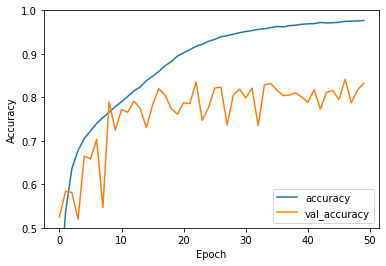

In [28]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds,
                                     verbose=2)
print("Validation stats:")
print(test_loss,test_acc)
test_loss, test_acc = model.evaluate(test_ds,
                                     verbose=2)
print("Test stats:")
print(test_loss,test_acc)


In [29]:
print(test_ds.class_indices)
print(train_ds.class_indices)
print(val_ds.class_indices)

{'bicycle': 0, 'bus': 1, 'car': 2, 'motor': 3, 'truck': 4, 'van': 5}
{'bicycle': 0, 'bus': 1, 'car': 2, 'motor': 3, 'truck': 4, 'van': 5}
{'bicycle': 0, 'bus': 1, 'car': 2, 'motor': 3, 'truck': 4, 'van': 5}


In [30]:
test_ds.reset()
y_pred = model.predict(test_ds)
predicted_categories = np.argmax(y_pred, axis = 1)
print(classification_report(test_ds.classes,predicted_categories))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       806
           1       0.67      0.79      0.73       446
           2       0.82      0.91      0.87      4300
           3       0.71      0.80      0.75      1186
           4       0.83      0.66      0.74       989
           5       0.74      0.53      0.62      1305

    accuracy                           0.79      9032
   macro avg       0.76      0.72      0.73      9032
weighted avg       0.79      0.79      0.78      9032



In [31]:
test_ds.reset()
y_pred = model.predict(test_ds)
predicted_categories = np.argmax(y_pred, axis = 1)
print(classification_report(test_ds.classes,predicted_categories,target_names=('bicycle','bus','car','motor','truck','van')))

              precision    recall  f1-score   support

     bicycle       0.77      0.64      0.70       806
         bus       0.67      0.79      0.73       446
         car       0.82      0.91      0.87      4300
       motor       0.71      0.80      0.75      1186
       truck       0.83      0.66      0.74       989
         van       0.74      0.53      0.62      1305

    accuracy                           0.79      9032
   macro avg       0.76      0.72      0.73      9032
weighted avg       0.79      0.79      0.78      9032



In [32]:
model.save("ALEXNET_v4.h5")

predicted_categories = np.argmax(y_pred, axis = 1)
#print(predicted_categories[:2])
print(train_ds.class_indices)
#print(val_ds.class_indices)
#print(test_ds.class_indices)
#print(len(test_ds.classes))

tf.keras.metrics.categorical_accuracy(,y_pred)
true_categories = tf.concat([y for x, y in test_ds], axis = 0).numpy() 
true_labels = np.argmax(true_categories, axis = 1)
print(type(true_labels))

print(classification_report(true_labels,predicted_categories))

STEP_SIZE_TEST=val_ds.n/val_ds.batch_size
val_ds.reset()
pred=model.predict_generator(val_ds,
steps=STEP_SIZE_TEST,
verbose=1)
predicted_categories = np.argmax(pred, axis = 1)
print(classification_report(true_labels,predicted_categories))

labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_categories]
print(classification_report(true_labels,predictions))
